# Competición Kaggle Diamantes 

In [77]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import pylab as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [2]:
# Descargamos los datos de train y test(Los datos de train son solo para entrenar y los datos de test son para predecir)

df = pd.read_csv(r'C:\Users\mario\OneDrive\Escritorio\Bootcamp\ds_tb_part_21_09\data\train_diamantes.csv') # Datos con el precio
df_2 = pd.read_csv(r'C:\Users\mario\OneDrive\Escritorio\Bootcamp\ds_tb_part_21_09\data\test_diamantes.csv') # Datos sin el precio
df_3 = pd.read_csv(r'C:\Users\mario\OneDrive\Escritorio\Bootcamp\ds_tb_part_21_09\data\sample.csv')

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,id
0,1.01,Very Good,F,SI2,62.2,58.0,4332.0,6.33,6.38,3.95,0
1,0.90,Very Good,I,VS2,61.4,58.0,4089.0,6.22,6.25,3.83,1
2,0.53,Ideal,E,VVS2,62.2,54.0,2273.0,5.19,5.23,3.24,2
3,0.32,Ideal,I,IF,60.8,54.0,673.0,4.44,4.47,2.71,3
4,1.06,Ideal,G,VVS2,61.0,57.0,7900.0,6.55,6.57,4.00,4


In [3]:
# Hacemos una copia del dataset original
df_train = df.copy()
df_test = df_2.copy()
df_shample = df_3.copy()

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35940 entries, 0 to 35939
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    35940 non-null  float64
 1   cut      35940 non-null  object 
 2   color    35940 non-null  object 
 3   clarity  35940 non-null  object 
 4   depth    35940 non-null  float64
 5   table    35940 non-null  float64
 6   price    35940 non-null  float64
 7   x        35940 non-null  float64
 8   y        35940 non-null  float64
 9   z        35940 non-null  float64
 10  id       35940 non-null  int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 3.0+ MB


In [5]:
df_train.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
id           int64
dtype: object

In [6]:
nan_cols=df_train.isna().sum()

nan_cols[nan_cols>0]  # columnas con nulos(No hay)

Series([], dtype: int64)

In [7]:
len(df_train) # tenemos 35940 filas

35940

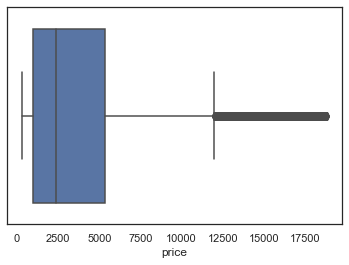

In [95]:
# Vemos los outliers
sns.boxplot(df_train['price']); # Tenemos bastantes outliers, el precio de algunos diamantes están muy por encima de lo normal

In [79]:
# Vemos los outliers
Q1 = df_train.price.quantile(.25)
Q3 = df_train.price.quantile(.75)
IQR = Q3 - Q1

outliers = df_train[(df_train.price < Q1-1.5 * IQR)|(df_train.price > Q3+1.5 * IQR)]

len(outliers) # Hay 2297 outliers, vamos a probar un modelo con outliers y otro sin estos ya que son datos reales

2297

### Primer modelo con outliers 

In [11]:
df_train.color.value_counts()

G    7655
E    6513
F    6309
H    5481
D    4448
I    3646
J    1888
Name: color, dtype: int64

In [12]:
df_train.cut.value_counts() # Hay una errata en Very Geod

Ideal        14352
Premium       9216
Very Good     6427
Good          3238
Very Geod     1627
Fair          1080
Name: cut, dtype: int64

In [13]:
df_train['cut'] = df_train.cut.replace('Very Geod', 'Very Good')

In [14]:
df_train.cut.value_counts() # Corregimos la errata

Ideal        14352
Premium       9216
Very Good     8054
Good          3238
Fair          1080
Name: cut, dtype: int64

In [15]:
df_train.clarity.value_counts()

SI1     8628
VS2     8244
SI2     6091
VS1     5492
VVS2    3326
VVS1    2457
IF      1217
I1       485
Name: clarity, dtype: int64

In [16]:
# Las columnas x, y, z parece que representan la profundidad (comprobamos), la profundidad sería z/((x + y)/2)
x = df_train['x'].iloc[0]
y = df_train['y'].iloc[0]
z = df_train['z'].iloc[0]
depth0 = df_train['depth'].iloc[0]

if np.round(z/((x+y)/2)*100, 1) == depth0:
    print('Is depth')
else:
    print('Is not depth')
    
# Efectivamente las columnas x, y, z representan la profundidad que ya la tenemos en el DataSet(eliminamos estas columnas)

Is depth


In [17]:
df_train = df_train.drop(['x', 'y', 'z', 'id'], axis = 1) # Eliminamos las columnas que de momento no nos valen

df_train.head()

,carat,cut,color,clarity,depth,table,price
0,1.01,Very Good,F,SI2,62.2,58.0,4332.0
1,0.90,Very Good,I,VS2,61.4,58.0,4089.0
2,0.53,Ideal,E,VVS2,62.2,54.0,2273.0
3,0.32,Ideal,I,IF,60.8,54.0,673.0
4,1.06,Ideal,G,VVS2,61.0,57.0,7900.0


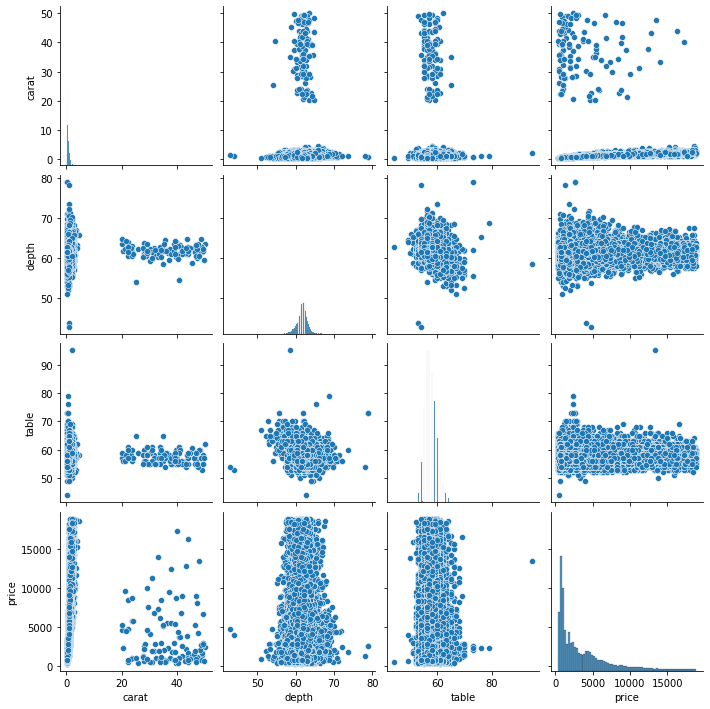

In [18]:
sns.pairplot(df_train); # Vemos posibles relaciones entre variables

In [19]:
df_train.describe()

,carat,depth,table,price
count,35940.000000,35940.000000,35940.000000,35940.000000
mean,0.907500,61.756210,57.461753,3930.117835
std,2.098015,1.431872,2.240414,3982.706797
min,0.200000,43.000000,44.000000,326.000000
25%,0.400000,61.100000,56.000000,949.000000
50%,0.700000,61.900000,57.000000,2394.000000
75%,1.050000,62.500000,59.000000,5362.250000
max,49.990359,79.000000,95.000000,18823.000000


In [20]:
print(np.max(df_train.depth), ',',np.min(df_train.depth)) # Están en porcentaje estos datos, dividimos la columna entre 100 para normalizarla

79.0 , 43.0


In [21]:
df_train['depth'] = df_train.depth.apply(lambda x: x/100)

df_train.head() # La columna depth la tenemos normalizada

,carat,cut,color,clarity,depth,table,price
0,1.01,Very Good,F,SI2,0.622,58.0,4332.0
1,0.90,Very Good,I,VS2,0.614,58.0,4089.0
2,0.53,Ideal,E,VVS2,0.622,54.0,2273.0
3,0.32,Ideal,I,IF,0.608,54.0,673.0
4,1.06,Ideal,G,VVS2,0.610,57.0,7900.0


' Parece que las variables están muy poco correlacionadas entre si, quizás un poco más la profundidad con la tabla que es la parte de arriba del diamante\n    Lo que está claro es que los quilates es lo más representativo del precio'

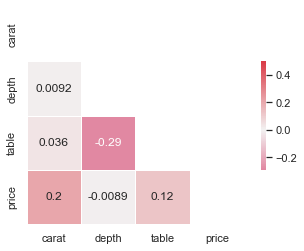

In [22]:
# Vamos a ver correlacioens entre variables numéricas, vemos colinealidad
corr = df_train[['carat', 'depth', 'table', 'price']].corr(method='pearson')

sns.set(style='white')  # estilo blanco

mask=np.triu(np.ones_like(corr, dtype=bool)) # genera una mascara para ocultar la triangular superior

cmap=sns.diverging_palette(0, 10, as_cmap=True) # paleta de colores con degradado


# heatmap o mapa de calor

sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=0.5,
            center=0, 
            square=True,
            linewidths=.5,
            cbar_kws={'shrink': .5},
            annot=True);

''' Parece que las variables están muy poco correlacionadas entre si, quizás un poco más la profundidad con la tabla que es la parte de arriba del diamante
    Lo que está claro es que los quilates es lo más representativo del precio'''

In [23]:
# Vemos si table también es una variable que está representada en porcentaje
print(np.max(df_train.table), ',',np.min(df_train.table)) 

95.0 , 44.0


In [24]:
# Normalizamos la variabletable dividiéndola entre 100
df_train['table'] = df_train.table.apply(lambda x: x/100)

df_train.head() # La columna table la tenemos normalizada

,carat,cut,color,clarity,depth,table,price
0,1.01,Very Good,F,SI2,0.622,0.58,4332.0
1,0.90,Very Good,I,VS2,0.614,0.58,4089.0
2,0.53,Ideal,E,VVS2,0.622,0.54,2273.0
3,0.32,Ideal,I,IF,0.608,0.54,673.0
4,1.06,Ideal,G,VVS2,0.610,0.57,7900.0


In [25]:
# Vamos a normalizar los quilates dividiendo toda la columna entre su máximo
np.max(df_train.carat), np.min(df_train.carat)

(49.9903589324094, 0.2)

In [26]:
df_train['carat'] = df_train.carat.apply(lambda x: x/np.max(df_train.carat))

df_train

,carat,cut,color,clarity,depth,table,price
0,0.020204,Very Good,F,SI2,0.622,0.58,4332.0
1,0.018003,Very Good,I,VS2,0.614,0.58,4089.0
2,0.010602,Ideal,E,VVS2,0.622,0.54,2273.0
3,0.006401,Ideal,I,IF,0.608,0.54,673.0
4,0.021204,Ideal,G,VVS2,0.610,0.57,7900.0
...,...,...,...,...,...,...,...
35935,0.006201,Ideal,F,VS1,0.616,0.56,695.0
35936,0.007001,Very Good,E,SI1,0.629,0.58,614.0
35937,0.009202,Ideal,F,SI2,0.615,0.54,758.0
35938,0.006201,Ideal,E,VS1,0.616,0.56,734.0


In [61]:
# Vamos a darle valores a las categorías en función de como afectan al precio
def cut(e):
    if e=="Ideal":
        return 0.95
    elif e=="Premium":
        return 1
    elif e=="Very Good":
        return 0.8
    elif e=="Good":
        return 0.5
    elif e=="Fair":
        return 0.1
    else:
        pass
    return e

In [62]:
# Vamos a darle valores a los colores en función de como afectan al precio
def color(e):
    if e=="D":
        return 1
    elif e=="E":
        return 0.85
    elif e=="F":
        return 0.91
    elif e=="G":
        return 0.8
    elif e=="H":
        return 0.76
    elif e=="I":
        return 0.5
    elif e=="J":
        return 0.1
    else:
        pass
    return e

In [63]:
# Vamos a darle valores a la claridad en función de como afectan al precio
def claridad(e):
    if e=="IF":
        return 1
    elif e=="VVS1":
        return 0.87
    elif e=="VVS2":
        return 0.78
    elif e=="VS1":
        return 0.65
    elif e=="VS2":
        return 0.5
    elif e=="SI1":
        return 0.25
    elif e=="SI2":
        return 0.2
    elif e=="I1":
        return 0.1
    else:
        pass
    return e

In [64]:
# Aplicamos a la base de datos
df_train["cut"]=df_train["cut"].apply(cut)
df_train["color"]=df_train["color"].apply(color)
df_train["clarity"]=df_train["clarity"].apply(claridad)

In [65]:
df_train.head()

,carat,cut,color,clarity,depth,table,price
0,0.020204,0.80,0.91,0.20,0.622,0.58,4332.0
1,0.018003,0.80,0.50,0.50,0.614,0.58,4089.0
2,0.010602,0.95,0.85,0.78,0.622,0.54,2273.0
3,0.006401,0.95,0.50,1.00,0.608,0.54,673.0
4,0.021204,0.95,0.80,0.78,0.610,0.57,7900.0


In [66]:
# Aplicamos el modelo Random Forest
X = df_train.drop(columns = ['price'])
y = df_train.price

In [67]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [68]:
from sklearn.ensemble import RandomForestRegressor as RFR

rfr=RFR()
rfr.fit(X_train, y_train) # Entrenamos el modelo

train_score=rfr.score(X_train, y_train)  # R2 score
test_score=rfr.score(X_test, y_test)


train_score, test_score # Hay algo de Overfitting (no demasiado)

(0.9965252356164621, 0.9750992960669994)

In [69]:
# Hacemos la predicción
y_pred=rfr.predict(X_test)

In [70]:
# Sacamos el Error absoluto medio
errors = abs(y_pred - y_test)
print('Error absoluto medio:', round(np.mean(errors), 2), 'grados.')

Error absoluto medio: 297.03 grados.


In [71]:
# Sacamos el porcentaje de acierto del modelo
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.59 %.


In [72]:
# Sacamos el error cuadrático medio
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, y_pred, squared=False)

rms

609.807303044409

In [39]:
# Vamos a transformar los datos del test para utilizarlos para predecir
len(df_test), len(df_shample)

(12000, 12000)

In [40]:
df_test.head()

,carat,cut,color,clarity,depth,table,x,y,z,id
0,0.70,Good,J,VVS2,64.3,56.0,5.57,5.63,3.60,0
1,0.31,Premium,E,VVS2,61.9,58.0,4.38,4.35,2.70,1
2,0.84,Premium,F,SI1,59.0,59.0,6.18,6.13,3.63,2
3,1.03,Fair,E,SI1,65.1,58.0,6.35,6.24,4.10,3
4,1.20,Premium,J,SI1,60.5,59.0,6.84,6.79,4.12,4


In [41]:
# Eliminamos las columnas que necesitemos y normalizamos las variables numéricas

df_test = df_test.drop(['x', 'y', 'z', 'id'], axis = 1) # Eliminamos las columnas que no nos valen

df_test['cut'] = df_test.cut.replace('Very Geod', 'Very Good') # Corregimos la errata

# Normalizamos las columnas
df_test['depth'] = df_test.depth.apply(lambda x: x/100) 

df_test['table'] = df_test.table.apply(lambda x: x/100)

df_test['carat'] = df_test.carat.apply(lambda x: x/np.max(df_test.carat))

# Convertimos las variables categóricas en numéricas
df_test["cut"]=df_test["cut"].apply(cut)
df_test["color"]=df_test["color"].apply(color)
df_test["clarity"]=df_test["clarity"].apply(claridad)

df_test.head()

,carat,cut,color,clarity,depth,table
0,0.014504,0.5,0.00,0.78,0.643,0.56
1,0.006423,1.0,0.85,0.78,0.619,0.58
2,0.017405,1.0,0.91,0.25,0.590,0.59
3,0.021342,0.0,0.85,0.25,0.651,0.58
4,0.024864,1.0,0.00,0.25,0.605,0.59


In [42]:
len(df_test), len(df_shample)

(12000, 12000)

In [48]:
# Hacemos la predicción
predictions=rfr.predict(df_test)

predictions[:10]

array([ 2028.45      ,   919.927     ,  3919.725     ,  4861.47      ,
        4698.115     ,   668.39333333,  2018.085     ,  2737.17666667,
       10537.37333333,  4041.06333333])

In [59]:
df_pred = pd.DataFrame({'Id': df_2.id,
                        'Predicted':predictions})

df_pred.head()

,Id,Predicted
0,0,2028.450
1,1,919.927
2,2,3919.725
3,3,4861.470
4,4,4698.115


In [60]:
df_pred.to_csv(r'C:\Users\mario\OneDrive\Escritorio\Bootcamp\ds_tb_part_21_09\03-Machine_Learning\Ejercicios\diamonds_pred.csv', index = False)

### Segundo modelo sin Outliers

In [80]:
# Cogemos el DataFrame sin los outliers
df_train_clean = df_train[~(((df_train.price < Q1-1.5 * IQR))|(df_train.price > Q3+1.5 * IQR))]

len(df_train_clean) # Eliminando los outliers nos quedan 33643 filas

33643

In [81]:
df_train_clean.head()

,carat,cut,color,clarity,depth,table,price
0,0.020204,0.80,0.91,0.20,0.622,0.58,4332.0
1,0.018003,0.80,0.50,0.50,0.614,0.58,4089.0
2,0.010602,0.95,0.85,0.78,0.622,0.54,2273.0
3,0.006401,0.95,0.50,1.00,0.608,0.54,673.0
4,0.021204,0.95,0.80,0.78,0.610,0.57,7900.0


In [82]:
# Eliminamos las columnas que necesitemos y normalizamos las variables numéricas

df_train_clean['cut'] = df_train_clean.cut.replace('Very Geod', 'Very Good') # Corregimos la errata

# Normalizamos las columnas
df_train_clean['depth'] = df_train_clean.depth.apply(lambda x: x/100) 

df_train_clean['table'] = df_train_clean.table.apply(lambda x: x/100)

df_train_clean['carat'] = df_train_clean.carat.apply(lambda x: x/np.max(df_train_clean.carat))

# Convertimos las variables categóricas en numéricas
df_train_clean["cut"]=df_train_clean["cut"].apply(cut)
df_train_clean["color"]=df_train_clean["color"].apply(color)
df_train_clean["clarity"]=df_train_clean["clarity"].apply(claridad)

df_train_clean.head()

,carat,cut,color,clarity,depth,table,price
0,0.020204,0.80,0.91,0.20,0.00622,0.0058,4332.0
1,0.018003,0.80,0.50,0.50,0.00614,0.0058,4089.0
2,0.010602,0.95,0.85,0.78,0.00622,0.0054,2273.0
3,0.006401,0.95,0.50,1.00,0.00608,0.0054,673.0
4,0.021204,0.95,0.80,0.78,0.00610,0.0057,7900.0


In [83]:
# Aplicamos el modelo Random Forest
X = df_train.drop(columns = ['price'])
y = df_train.price

In [84]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [85]:
from sklearn.ensemble import RandomForestRegressor as RFR

rfr=RFR()
rfr.fit(X_train, y_train) # Entrenamos el modelo

train_score=rfr.score(X_train, y_train)  # R2 score
test_score=rfr.score(X_test, y_test)


train_score, test_score # Hay algo de Overfitting (no demasiado)

(0.9965693867758086, 0.9756472315816765)

In [86]:
# Hacemos la predicción
y_pred=rfr.predict(X_test)

In [87]:
# Sacamos el Error absoluto medio
errors = abs(y_pred - y_test)
print('Error absoluto medio:', round(np.mean(errors), 2), 'grados.')

Error absoluto medio: 297.89 grados.


In [88]:
# Sacamos el porcentaje de acierto del modelo
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.64 %.


In [89]:
# Sacamos el error cuadrático medio
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, y_pred, squared=False)

rms # Mejoramos algo el modelo, no demasiado 

603.0606317160059

In [91]:
# Predecimos con las transformacioens hechas
predictions=rfr.predict(df_test)

predictions[:10]

array([ 2013.87      ,   905.58666667,  3952.27      ,  5036.10166667,
        4706.21      ,   677.69      ,  2030.615     ,  2726.4725    ,
       10484.99333333,  4053.385     ])

In [92]:
df_pred_2 = pd.DataFrame({'Id': df_2.id,
                        'Predicted':predictions})

df_pred_2.head()

,Id,Predicted
0,0,2013.870000
1,1,905.586667
2,2,3952.270000
3,3,5036.101667
4,4,4706.210000


In [93]:
df_pred_2.to_csv(r'C:\Users\mario\OneDrive\Escritorio\Bootcamp\ds_tb_part_21_09\03-Machine_Learning\Ejercicios\diamonds_pred_2.csv', index = False)